# Cartpole example

In [1]:
import cvxpy as cp
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import sympy as sp

import os
import sys
sys.path.append(os.path.join(".."))

import scocp

In [2]:
np.set_printoptions(precision=4)

## 0. Define the dynamics

We first need to define the dynamics functions; let $x \in \mathbb{R}^{n_x}$ denote the state, $u \in \mathbb{R}^{n_u}$ denote the control, and let 

$$
\dot{x}(t) = f(x(t), u(t), t)
$$


We need to prepare the following functions:

1. `rhs_eom(t,x,u)` : compute the deriative of the state `x` with control `u` at time `t`
2. `rhs_eom_aug(t,x_aug,u)` : compute the deriative of the augmented state `x_aug` with control `u` at time `t`

where the augmented state `x_aug` consists of

$$
x_{\mathrm{aug}} = \begin{bmatrix}
    x \\ \operatorname{vec}(\Phi_A) \\ \operatorname{vec}(\Phi_B)
\end{bmatrix}
$$

The dynamics of the augmented state is given by

$$
\dot{x}_{\mathrm{aug}} = \begin{bmatrix}
    f(x(t), u(t), t) \\ \operatorname{vec}(A \Phi_A) \\ \operatorname{vec}(A \Phi_B + B)
\end{bmatrix}
$$

where $A = \partial f/\partial x$ and $B = \partial f/\partial u$, with initial conditions

$$
\begin{cases}
    x(t_0) = x_0
    \\
    \Phi_A = I_{n_x}
    \\
    \Phi_B = 0_{n_x \times n_u}
\end{cases}
$$

We will use `sympy`'s `jacobian()` function to generate expressions for $A$ and $B$, and construct the functions `scipy_rhs_eom` and `scipy_rhs_eom_augmented`.

In [6]:
# dynamics parameters
mc = 1.0     # cart mass
mp = 0.2     # pole mass
l  = 0.5     # pole length
g  = 9.81    # gravity

def get_dynamics():
    # construct dynamics
    n_x, n_u = 4,1
    _x = sp.IndexedBase('x')
    _u = sp.IndexedBase('u')
    x = sp.Matrix([_x[i] for i in range(n_x)])
    u = sp.Matrix([_u[i] for i in range(n_u)])

    # dynamics
    f_sym = sp.Matrix([
        x[2],
        x[3],
        1/(mc + mp*sp.sin(x[1])**2) * (u[0] + mp*sp.sin(x[1])*(l*x[3]**2 + g*sp.cos(x[1]))),
        1/(l*(mc + mp*sp.sin(x[1])**2)) * (-u[0]*sp.cos(x[1]) - mp*l*x[3]**2*sp.sin(x[1])*sp.cos(x[1]) - (mc + mp)*g*sp.sin(x[1]))
    ])

    # jacobian
    jac_x_sym = f_sym.jacobian(x)
    jac_u_sym = f_sym.jacobian(u)

    # we make numerical functions for dynamics and dynamics with STM
    eval_dymamics = sp.lambdify([x,u], f_sym, modules = [{'atan2':np.arctan2}, 'numpy'])
    eval_dfdx = sp.lambdify([x,u], jac_x_sym, modules = [{'atan2':np.arctan2}, 'numpy'])
    eval_dfdu = sp.lambdify([x,u], jac_u_sym, modules = [{'atan2':np.arctan2}, 'numpy'])

    scipy_rhs_eom = lambda t, x, u: eval_dymamics(x, u).flatten()
    
    def scipy_rhs_eom_augmented(t, x, u):
        assert len(x) == n_x + n_x*n_x + n_x*n_u, f"x must be of length {n_x + n_x*n_x + n_x*n_u}, but got {len(x)}"
        dxdt_aug = np.zeros(n_x + n_x*n_x + n_x*n_u)
        dxdt_aug[:n_x] = scipy_rhs_eom(t, x[:n_x], u)
        A = eval_dfdx(x[:n_x], u)
        B = eval_dfdu(x[:n_x], u)
        dxdt_aug[n_x:n_x*(n_x+1)] = (A @ x[n_x:n_x*(n_x+1)].reshape(n_x,n_x)).flatten()
        dxdt_aug[n_x*(n_x+1):]    = (np.dot(A, x[n_x*(n_x+1):].reshape(n_x,n_u)) + B).flatten()
        return dxdt_aug
    return scipy_rhs_eom, scipy_rhs_eom_augmented

In [7]:
scipy_rhs_eom, scipy_rhs_eom_augmented = get_dynamics()

In [8]:
x0 = np.array([0.0, 0.23, 0.31, -0.26])
u0 = np.array([0.2])

scipy_rhs_eom(0.0, x0, u0)

array([ 0.31  , -0.26  ,  0.6305, -5.7007])

In [9]:
foo = scipy_rhs_eom_augmented(0.0, np.concatenate((x0, np.eye(4).flatten(), np.zeros((4,1)).flatten())), u0)
foo[4:20].reshape(4,4)

array([[ 0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00],
       [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00],
       [ 0.0000e+00,  1.6911e+00,  0.0000e+00, -1.1733e-02],
       [ 0.0000e+00, -2.2109e+01,  0.0000e+00,  2.2848e-02]])

In [10]:
# build integrator object
integrator = scocp.ScipyIntegrator(
    nx = 4,
    nu = 1,
    rhs = scipy_rhs_eom,
    rhs_stm = scipy_rhs_eom_augmented,
    impulsive = False,
    args = ([0.0,],),             # place holder for control
    method = 'RK45',
    reltol = 1e-8,
    abstol = 1e-8
)

In [11]:
times, states = integrator.solve(tspan = [0, 1.0], x0 = x0, u = u0, stm=True)

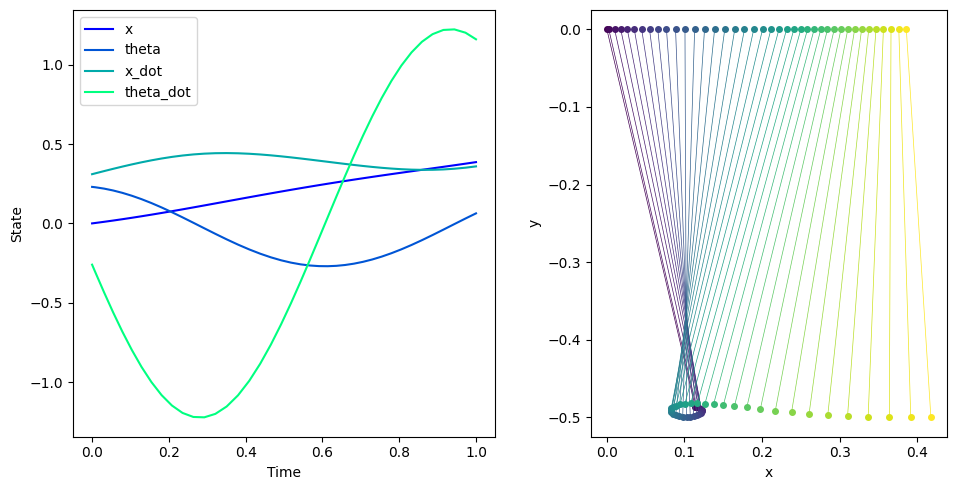

In [12]:
# test integration
times, states = integrator.solve(tspan = [0, 1.0], x0 = x0, u = u0)

# quick plot
state_labels = ["x", "theta", "x_dot", "theta_dot"]
colors = cm.winter(np.linspace(0, 1, 4))
fig, axs = plt.subplots(1,2,figsize=(10,5))
for ix in range(4):
    axs[0].plot(times, states[:,ix], label=state_labels[ix], color=colors[ix])
axs[0].legend()
axs[0].set(xlabel="Time", ylabel="State")

colors = cm.viridis(np.linspace(0, 1, len(times)))
for i in range(len(times)):
    axs[1].plot(
        [states[i,0], states[i,0] + l * np.sin(states[i,1])],
        [0.0, -l * np.cos(states[i,1])],
        marker="o", color=colors[i], linewidth=0.5, ms=4)
axs[1].set(xlabel="x", ylabel="y")
axs[1].set_aspect('equal')
plt.tight_layout()
plt.show()

## 1a. Unconstrained optimal control problem with quadratic objective

Let's consider an energy-optimal, unconstrained OCP of the form

$$
\begin{aligned}
\min_{x,u} \quad& \sum_{k=0}^{N-1} u_k^T u_k
\\ \text{s.t.} \quad&
    x_{k+1} = F(x_k, u_k)
    \quad \forall k = 0,\ldots,N-1
\\&
    x_0 = x_{\mathrm{initial}}
\\&
    \begin{bmatrix} \theta \\ \dot{x} \\ \dot{\theta} \end{bmatrix}_{N} = \begin{bmatrix} 0 \\ 0 \\ 0 \end{bmatrix}
\end{aligned}
$$

In [50]:
x_initial = np.array([0.0, 0.0, 0.0, 0.0])
x_target = np.array([0.0, np.pi, 0.0, 0.0])

In [65]:
class CartPoleProblem(scocp.ContinuousControlSCOCP):
    def __init__(self, integrator, times, trust_region_radius):
        super().__init__(integrator, times, trust_region_radius = trust_region_radius)
        return
    
    def evaluate_objective(self, xs, us, vs, ys=None):
        """Quadratic objective function"""
        return 0.5 * np.sum(us.T @ us)

    def solve_convex_problem(self, xbar, ubar, vbar=None, ybar=None):
        """Solve the convex subproblem"""
        N,nx = xbar.shape
        _,nu = ubar.shape
        Nseg = N - 1
        
        xs = cp.Variable((N, nx), name='state')
        us = cp.Variable((Nseg, nu), name='control')
        xis_dyn = cp.Variable((Nseg,nx), name='xi_dyn')         # slack for dynamics
        
        penalty = scocp.get_augmented_lagrangian_penalty(self.weight, xis_dyn, self.lmb_dynamics)
        R = np.eye(Nseg)
        objective_func = 0.5 * cp.quad_form(us, R) + penalty

        constraints_dyn = [
            xs[i+1,:] == self.Phi_A[i,:,:] @ xs[i,:] + self.Phi_B[i,:,:] @ us[i,:] + self.Phi_c[i,:] + xis_dyn[i,:]
            for i in range(Nseg)
        ]

        constraints_trustregion = [
            xs[i,:] - xbar[i,:] <= self.trust_region_radius for i in range(N)
        ] + [
            xs[i,:] - xbar[i,:] >= -self.trust_region_radius for i in range(N)
        ]

        constraints_initial = [xs[0,:] == x_initial]
        constraints_final   = [xs[-1,1:4] == x_target[1:4]]

        convex_problem = cp.Problem(
            cp.Minimize(objective_func),
            constraints_dyn + constraints_trustregion + constraints_initial + constraints_final)
        convex_problem.solve(solver = self.solver, verbose = self.verbose_solver)
        self.cp_status = convex_problem.status
        return xs.value, us.value, None, None, xis_dyn.value, None, None

In [66]:
# create discretized time grid
N = 40
tf = 5.0
times = np.linspace(0, tf, N)
trust_region_radius = 0.5

# create optimal control problem object
problem = CartPoleProblem(integrator, times, trust_region_radius)

# create some initial guess and try solving the subproblem
np.random.seed(0)
xs_initial_guess = np.zeros((N, 4))
xs_initial_guess[:,1] = np.linspace(0, np.pi, N)
xs_initial_guess[ 0,:] = x_initial
xs_initial_guess[-1,:] = x_target                  # we set the final state of the initial guess to the targeted state 
us_initial_guess = np.zeros((N-1, 1))

# solve the subproblem
problem.verbose_solver = True
_ = problem.solve_convex_problem(xs_initial_guess, us_initial_guess)

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) Jun 11 11:23:05 PM: Your problem has 355 variables, 483 constraints, and 0 parameters.


(CVXPY) Jun 11 11:23:05 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 11 11:23:05 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 11 11:23:05 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jun 11 11:23:05 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 11 11:23:05 PM: Compiling problem (target solver=CLARABEL).
(CVXPY) Jun 11 11:23:05 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> CLARABEL
(CVXPY) Jun 11 11:23:05 PM: Applying reduction Dcp2Cone
(CVXPY) Jun 11 11:23:05 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jun 11 11:23:05 PM: 

In [67]:
# let's solve the full nonlinear problem
problem.verbose_solver = False
tol_feas = 1e-6
tol_opt = 1e-4
algo = scocp.SCvxStar(problem, tol_opt=tol_opt, tol_feas=tol_feas)
solution = algo.solve(
    xs_initial_guess,
    us_initial_guess,
    maxiter = 100,
    verbose = True
)


|  Iter  |     J0      |   Delta J   |   Delta L   |    chi     |     rho     |     r      |   weight   | step acpt. |
     1   |  3.3894e+02 |  5.1505e+03 |  3.8849e+03 | 2.1607e+00 |  1.3258e+00 | 5.0000e-01 | 1.0000e+02 |    yes     |
     2   |  1.7787e+02 |  5.2331e+03 |  5.5749e+03 | 2.1524e+00 |  9.3869e-01 | 1.5000e+00 | 2.0000e+02 |    yes     |
     3   |  5.3729e+01 |  5.7384e+02 |  9.6888e+02 | 1.0566e+00 |  5.9227e-01 | 4.5000e+00 | 2.0000e+02 |    yes     |
     4   |  5.6561e+01 |  1.3932e+03 |  2.4924e+03 | 1.6101e+00 |  5.5896e-01 | 4.5000e+00 | 4.0000e+02 |    yes     |
     5   |  5.4305e+01 | -5.3579e+03 |  4.9380e+03 | 3.4130e+00 | -1.0850e+00 | 4.5000e+00 | 8.0000e+02 |    no      |
     6   |  7.1639e+01 |  4.2316e+03 |  4.9105e+03 | 4.1386e-01 |  8.6175e-01 | 2.2500e+00 | 8.0000e+02 |    yes     |
     7   |  6.9961e+01 | -3.7041e+03 |  6.8215e+02 | 1.8741e+00 | -5.4300e+00 | 6.7500e+00 | 8.0000e+02 |    no      |
     8   |  6.9961e+01 | -3.7041e+03 |  6.8215e

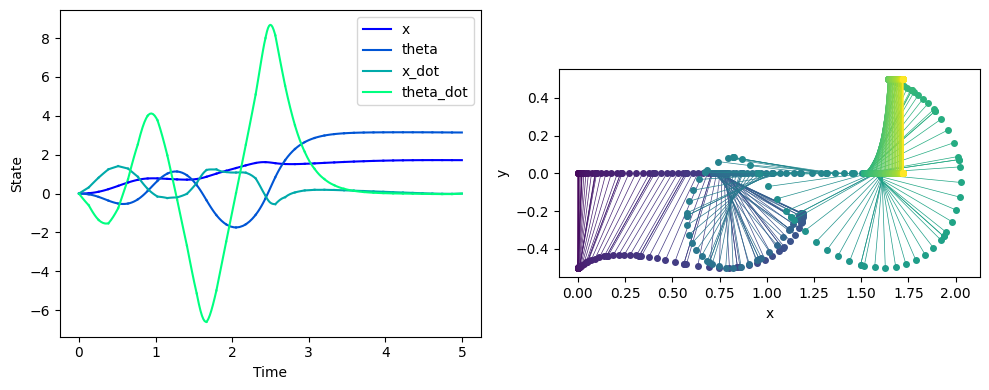

In [68]:
# plot results
state_labels = ["x", "theta", "x_dot", "theta_dot"]
colors = cm.winter(np.linspace(0, 1, 4))
fig, axs = plt.subplots(1,2,figsize=(10,4))
for itime, (_times,_states) in enumerate(solution.sols):
    for ix in range(4):
        if itime == 0:
            _label = state_labels[ix]
        else:
            _label = None
        axs[0].plot(_times, _states[:,ix], label=_label, color=colors[ix])
axs[0].legend()
axs[0].set(xlabel="Time", ylabel="State")

times_cat  = np.concatenate([_times  for _times,_  in solution.sols])
states_cat = np.concatenate([_states for _,_states in solution.sols])
colors = cm.viridis(np.linspace(0, 1, len(times_cat)))
for i in range(len(times_cat)):
    axs[1].plot(
        [states_cat[i,0], states_cat[i,0] + l * np.sin(states_cat[i,1])],
        [0.0, -l * np.cos(states_cat[i,1])],
        marker="o", color=colors[i], linewidth=0.5, ms=4)
axs[1].set(xlabel="x", ylabel="y")
axs[1].set_aspect('equal')
plt.tight_layout()
fig.savefig("./plots/cartpole_quadratic_state_history.png", dpi=200, bbox_inches='tight')
plt.show()

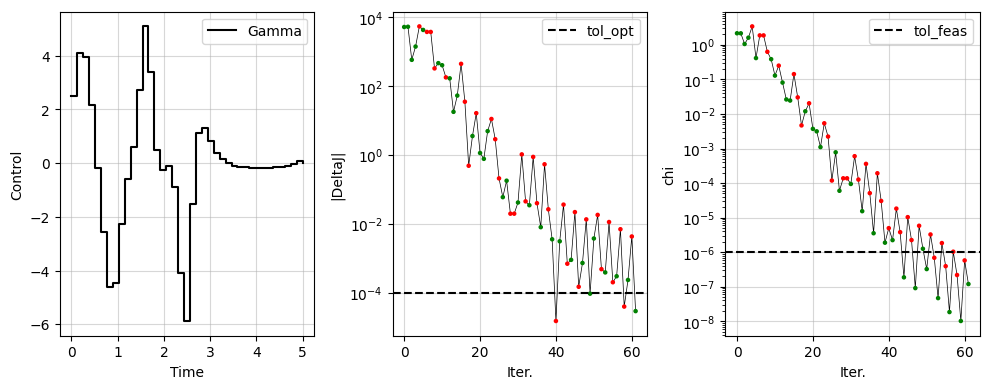

In [69]:
# plot results
fig = plt.figure(figsize=(10,4))
ax_u = fig.add_subplot(1,3,1)
ax_u.grid(True, alpha=0.5)
ax_u.step(problem.times, np.concatenate((solution.u[:,0], [0.0])), label="Gamma", where='post', color='k')
ax_u.set(xlabel="Time", ylabel="Control")
ax_u.legend()

ax_DeltaJ = fig.add_subplot(1,3,2)
ax_DeltaJ.grid(True, alpha=0.5)
algo.plot_DeltaJ(ax_DeltaJ, solution.summary_dict)
ax_DeltaJ.axhline(tol_opt, color='k', linestyle='--', label='tol_opt')
ax_DeltaJ.legend()

ax_DeltaL = fig.add_subplot(1,3,3)
ax_DeltaL.grid(True, alpha=0.5)
algo.plot_chi(ax_DeltaL, solution.summary_dict)
ax_DeltaL.axhline(tol_feas, color='k', linestyle='--', label='tol_feas')
ax_DeltaL.legend()

plt.tight_layout()
fig.savefig("./plots/cartpole_quadratic_convergence.png", dpi=200, bbox_inches='tight')
plt.show()

## 1b. Control-constrained optimal control problem with fuel-minimum objective

Let's now consider the case where we have a fuel-minimizing objectiv with a maximum control magnitude constraint.
For each control $u_k \in \mathbb{R}^{n_u}$, we introduce a slack variable $v_k \in \mathbb{R}$ corresponding to its magnitude, i.e. $\| u_k \|_2 = v_k$. Via loss-less relaxation, we consider the constraint $\| u_k \|_2 \leq v_k$, and obtain the OCP of the form

$$
\begin{aligned}
\min_{x,u,v} \quad& \sum_{k=0}^{N-1} v_k
\\ \text{s.t.} \quad&
    x_{k+1} = F(x_k, u_k)
    \quad \forall k = 0,\ldots,N-1
\\&
    x_0 = x_{\mathrm{initial}}
\\&
    \begin{bmatrix} \theta \\ \dot{x} \\ \dot{\theta} \end{bmatrix}_{N} = \begin{bmatrix} 0 \\ 0 \\ 0 \end{bmatrix}
\\&
    \| u_k \|_2 \leq v_k
    \quad \forall k = 0,\ldots,N-1
\\&
    v_k \leq u_{\max}
    \quad \forall k = 0,\ldots,N-1
\end{aligned}
$$

Note that specifically with the cartpole example, because the control input is a scalar, we could have instead introduced slacks to rewrite the objective with L1-norm; we however stick to the SOC-based formulation here, as this approach is used for fuel-optimal formulations where $n_u > 1$.

In [57]:
x_initial = np.array([0.0, 0.0, 0.0, 0.0])
x_target = np.array([0.0, np.pi, 0.0, 0.0])
umax = 4.0    # max control magnitude

In [58]:
class FuelOptimalCartPoleProblem(scocp.ContinuousControlSCOCP):
    def __init__(self, integrator, times, trust_region_radius):
        super().__init__(integrator, times, trust_region_radius = trust_region_radius)
        return
    
    def evaluate_objective(self, xs, us, vs, ys=None):
        """Quadratic objective function"""
        return np.sum(vs)

    def solve_convex_problem(self, xbar, ubar, vbar, ybar=None):
        """Solve the convex subproblem"""
        N,nx = xbar.shape
        _,nu = ubar.shape
        Nseg = N - 1
        
        xs = cp.Variable((N, nx), name='state')
        us = cp.Variable((Nseg, nu), name='control')
        vs = cp.Variable((Nseg, 1), name='Gamma', )
        xis_dyn = cp.Variable((Nseg,nx), name='xi_dyn')         # slack for dynamics
        
        penalty = scocp.get_augmented_lagrangian_penalty(self.weight, xis_dyn, self.lmb_dynamics)
        objective_func = cp.sum(vs) + penalty
        constraints_objsoc = [cp.SOC(vs[i,0], us[i,:]) for i in range(N-1)]
        constraints_umax = [vs[i,0] <= umax for i in range(N-1)]

        constraints_dyn = [
            xs[i+1,:] == self.Phi_A[i,:,:] @ xs[i,:] + self.Phi_B[i,:,:] @ us[i,:] + self.Phi_c[i,:] + xis_dyn[i,:]
            for i in range(Nseg)
        ]

        constraints_trustregion = [
            xs[i,:] - xbar[i,:] <= self.trust_region_radius for i in range(N)
        ] + [
            xs[i,:] - xbar[i,:] >= -self.trust_region_radius for i in range(N)
        ]

        constraints_initial = [xs[0,:] == x_initial]
        constraints_final   = [xs[-1,1:4] == x_target[1:4]]

        convex_problem = cp.Problem(
            cp.Minimize(objective_func),
            constraints_objsoc + constraints_umax + constraints_dyn + constraints_trustregion \
                + constraints_initial + constraints_final)
        convex_problem.solve(solver = self.solver, verbose = self.verbose_solver)
        self.cp_status = convex_problem.status
        return xs.value, us.value, vs.value, None, xis_dyn.value, None, None

In [59]:
# create discretized time grid
N = 40
tf = 5.0
times = np.linspace(0, tf, N)
trust_region_radius = 0.5

# create optimal control problem object
problem = FuelOptimalCartPoleProblem(integrator, times, trust_region_radius)

# create some initial guess and try solving the subproblem
np.random.seed(0)
xs_initial_guess = np.zeros((N, 4))
xs_initial_guess[:,1] = np.linspace(0, np.pi, N)
xs_initial_guess[ 0,:] = x_initial
xs_initial_guess[-1,:] = x_target                  # we set the final state of the initial guess to the targeted state 
us_initial_guess = np.zeros((N-1, 1))
vs_initial_guess = np.linalg.norm(us_initial_guess, axis=1).reshape(-1,1)

# solve the subproblem
problem.verbose_solver = True
_ = problem.solve_convex_problem(xs_initial_guess, us_initial_guess, vs_initial_guess)

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) Jun 11 11:21:54 PM: Your problem has 394 variables, 561 constraints, and 0 parameters.
(CVXPY) Jun 11 11:21:54 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 11 11:21:54 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 11 11:21:54 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jun 11 11:21:54 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 11 11:21:54 PM: Compiling problem (target solver=CLARABEL

In [60]:
# let's solve the full nonlinear problem
problem.verbose_solver = False
tol_feas = 1e-6
tol_opt = 1e-4
algo = scocp.SCvxStar(problem, tol_opt=tol_opt, tol_feas=tol_feas)
solution = algo.solve(
    xs_initial_guess,
    us_initial_guess,
    vs_initial_guess,           # now we also need to pass an initial guess of v's
    maxiter = 100,
    verbose = True
)


|  Iter  |     J0      |   Delta J   |   Delta L   |    chi     |     rho     |     r      |   weight   | step acpt. |
     1   |  9.4372e+01 |  5.1818e+03 |  3.8363e+03 | 2.1551e+00 |  1.3507e+00 | 5.0000e-01 | 1.0000e+02 |    yes     |
     2   |  3.2293e+01 |  6.1981e+03 |  6.2765e+03 | 1.5516e+00 |  9.8752e-01 | 1.5000e+00 | 2.0000e+02 |    yes     |
     3   |  2.8693e+01 |  5.4178e+02 |  7.1876e+02 | 9.9168e-01 |  7.5376e-01 | 4.5000e+00 | 2.0000e+02 |    yes     |
     4   |  5.7151e+01 | -4.9653e+03 |  1.4743e+03 | 3.6995e+00 | -3.3679e+00 | 1.0000e+01 | 4.0000e+02 |    no      |
     5   |  5.6787e+01 | -1.1509e+02 |  1.4673e+03 | 1.2773e+00 | -7.8438e-02 | 5.0000e+00 | 4.0000e+02 |    no      |
     6   |  5.6313e+01 |  1.3003e+03 |  1.4240e+03 | 4.4490e-01 |  9.1309e-01 | 2.5000e+00 | 4.0000e+02 |    yes     |
     7   |  5.6541e+01 |  5.2812e+02 |  6.6385e+02 | 2.4345e-01 |  7.9554e-01 | 7.5000e+00 | 8.0000e+02 |    yes     |
     8   |  5.5761e+01 |  7.6363e+02 |  8.0841e

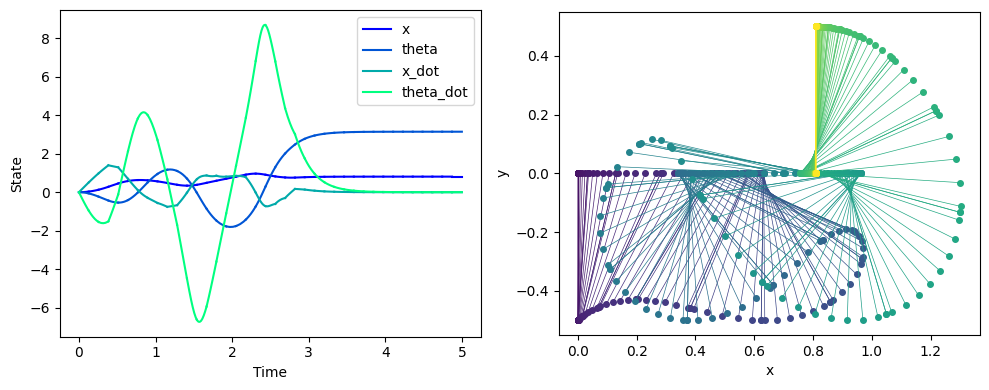

In [64]:
# plot results
state_labels = ["x", "theta", "x_dot", "theta_dot"]
colors = cm.winter(np.linspace(0, 1, 4))
fig, axs = plt.subplots(1,2,figsize=(10,4))
for itime, (_times,_states) in enumerate(solution.sols):
    for ix in range(4):
        if itime == 0:
            _label = state_labels[ix]
        else:
            _label = None
        axs[0].plot(_times, _states[:,ix], label=_label, color=colors[ix])
axs[0].legend()
axs[0].set(xlabel="Time", ylabel="State")

times_cat  = np.concatenate([_times  for _times,_  in solution.sols])
states_cat = np.concatenate([_states for _,_states in solution.sols])
colors = cm.viridis(np.linspace(0, 1, len(times_cat)))
for i in range(len(times_cat)):
    axs[1].plot(
        [states_cat[i,0], states_cat[i,0] + l * np.sin(states_cat[i,1])],
        [0.0, -l * np.cos(states_cat[i,1])],
        marker="o", color=colors[i], linewidth=0.5, ms=4)
axs[1].set(xlabel="x", ylabel="y")
axs[1].set_aspect('equal')
plt.tight_layout()
fig.savefig("./plots/cartpole_fueloptimal_state_history.png", dpi=200, bbox_inches='tight')
plt.show()

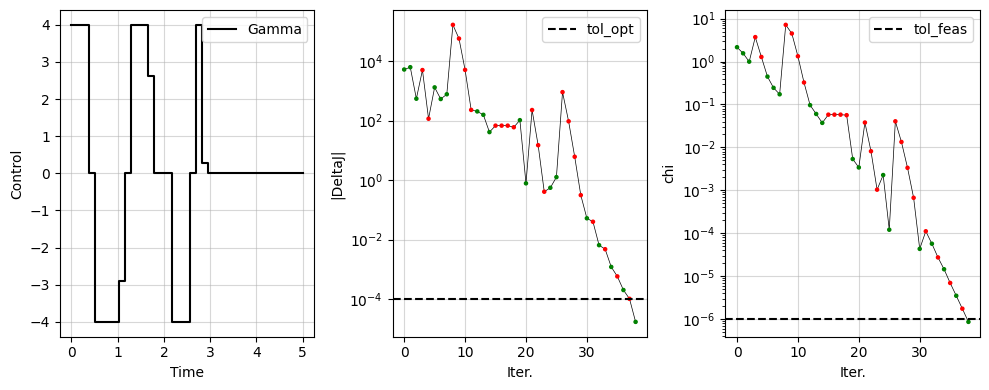

In [63]:
# plot results
fig = plt.figure(figsize=(10,4))
ax_u = fig.add_subplot(1,3,1)
ax_u.grid(True, alpha=0.5)
ax_u.step(problem.times, np.concatenate((solution.u[:,0], [0.0])), label="Gamma", where='post', color='k')
ax_u.set(xlabel="Time", ylabel="Control")
ax_u.legend()

ax_DeltaJ = fig.add_subplot(1,3,2)
ax_DeltaJ.grid(True, alpha=0.5)
algo.plot_DeltaJ(ax_DeltaJ, solution.summary_dict)
ax_DeltaJ.axhline(tol_opt, color='k', linestyle='--', label='tol_opt')
ax_DeltaJ.legend()

ax_DeltaL = fig.add_subplot(1,3,3)
ax_DeltaL.grid(True, alpha=0.5)
algo.plot_chi(ax_DeltaL, solution.summary_dict)
ax_DeltaL.axhline(tol_feas, color='k', linestyle='--', label='tol_feas')
ax_DeltaL.legend()

plt.tight_layout()
fig.savefig("./plots/cartpole_fueloptimal_convergence.png", dpi=200, bbox_inches='tight')
plt.show()